# Домашнее задание 2. Классификация изображений.

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в есть датасете. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train/ и val/, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат, собственно, сами изображения.
 
__Задание__. Необходимо выполнить два задания

1) Добейтесь accuracy **на валидации не менее 0.44**. В этом задании **запрещено** пользоваться предобученными моделями и ресайзом картинок. 5 баллов

2) Добейтесь accuracy **на валидации не менее 0.84**. В этом задании делать ресайз и использовать претрейн можно. 5 баллов

Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи / блогпосты / вопросы на stackoverflow / видосы от ютуберов-машинлернеров / курсы / подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете. 

Ваш код обязательно должен проходить все `assert`'ы ниже.

__Использовать внешние данные для обучения строго запрещено в обоих заданиях. Также запрещено обучаться на валидационной выборке__.


__Критерии оценки__: Оценка вычисляется по простой формуле: `min(10, 10 * Ваша accuracy / 0.44)` для первого задания и `min(10, 10 * (Ваша accuracy - 0.5) / 0.34)` для второго. Оценка округляется до десятых по арифметическим правилам.


__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать :)
 - Используйте аугментации. Для этого пользуйтесь модулем `torchvision.transforms` или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - Можно обучать с нуля или файнтюнить (в зависимости от задания) модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом `ImageFolder`), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы быстро отладить код, пробуйте обучаться на маленькой части датасета (скажем, 5-10 картинок просто чтобы убедиться что код запускается). Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать GPU. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.
 
Good luck & have fun! :)

In [ ]:
# !pip install wandb
# !pip3 install pytorch_lightning torchmetrics

**✨ Внимание ✨**

В этом домашнем задании предлагается использовать библиотеку `pytorch_lightning`. Доступ к ее [документации](https://lightning.ai/docs/pytorch/stable/) заблокирован с территории РФ. Вы можете:

1. Получить к ней доступ с помощью VPN.

2. Собрать документацию самостоятельно. Для этого склонируйте [github-репозиторий](https://github.com/Lightning-AI/lightning/tree/master), запустите в нем терминал (на windows – git bash) и выполните команды:

```shell
git submodule update --init --recursive
make docs
```
После этого откройте появившийся файл `docs/build/html/index.html`. Для работы команд в вашем окружении должен быть `pip`. Полная инструкция [по ссылке](https://github.com/Lightning-AI/lightning/tree/master/docs).

3. Гуглить `<error message> pytorch lightning` или `<how to do this> pytorch lightning`. Stack overflow на территории РФ все еще доступен 😉

4. Не пользоваться `pytorch_lightning` и написать цикл обучения модели самостоятельно. Например, по аналогии с функцией `fit` из [семинара 4](https://github.com/hse-ds/iad-deep-learning/blob/master/2023/seminars/04.%20Optim%20%26%20Lightning/04_Optim%26Lightning_solution.ipynb).

In [18]:
import random
import numpy as np
import torch
import torchvision.transforms as transforms
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from torchvision.models import densenet121, DenseNet121_Weights
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm import tqdm
from typing import Any
from torchmetrics.classification import Accuracy
from torchvision.transforms import Compose, Normalize, ToTensor
import shutil
import os


In [5]:
def seed_everything(seed):
    """
    Функция для установки случайных сидов в различных библиотеках.

    :param seed: Зерно для генерации случайных чисел
    """
    random.seed(seed)# Сид для библиотеки random
    os.environ["PYTHONHASHSEED"] = str(seed) # Cид для генерации хешей в Python (например, при использовании хеш-таблиц)
    np.random.seed(seed) # Cид для библиотеки NumPy
    torch.manual_seed(seed) # Cид для библиотеки PyTorch (генератор случайных чисел на CPU)
    torch.cuda.manual_seed(seed) # Cид для генератора случайных чисел на GPU (если используется CUDA)
    torch.backends.cudnn.deterministic = True

seed_everything(123456)


## Задание 0

### Что поможет сделать на 10 из 10 (одно задание - 5 баллов)

1. Использовать все возможные методы оптимизации и эксперемнтировать с ними.
2. Подбор learning rate. Пример из прошлого семинара как это делать: [Как найти lr](https://pytorch-lightning.readthedocs.io/en/1.4.5/advanced/lr_finder.html)

```
  trainer = pl.Trainer(accelerator="gpu", max_epochs=2, auto_lr_find=True) 

  trainer.tune(module, train_dataloader, eval_dataloader)

  trainer.fit(module, train_dataloader, eval_dataloader))
```



3. Аугментация данных. [Документация (полезная)](https://pytorch.org/vision/main/transforms.html), а также [библиотека albumentation](https://towardsdatascience.com/getting-started-with-albumentation-winning-deep-learning-image-augmentation-technique-in-pytorch-47aaba0ee3f8)
4. Подбор архитектуры модели. 
5. Можно написать модель руками свою в YourNet, а можно импортировать не предобученную сетку известной архитектуры из модуля torchvision.models. Один из способов как можно сделать: 

  * `torchvision.models.resnet18(pretrained=False, num_classes=200).to(device)`
  * Документация по возможным моделям и как их можно брать: [Документация (полезная)](https://pytorch.org/vision/stable/models.html)
6. Правильно нормализовывать данные при создании, пример [тык, но тут и в целом гайд от и до](https://www.pluralsight.com/guides/image-classification-with-pytorch)
7. Model Checkpointing. Сохраняйте свой прогресс (модели), чтобы когда что-то пойдет не так вы сможете начать с этого места или просто воспроизвести свои результаты модели, которые обучали. 
 * Пример как можно с wandb тут: [Сохраняем лучшие модели в wandb](https://docs.wandb.ai/guides/integrations/lightning)
 * По простому можно так: [Сохраняем модели в pytorch дока](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

### Подготовка данных

In [6]:
# Создание списка преобразований для обучающих данных
train_transform = Compose([
    # Случайное вращение изображения на угол до 15 градусов
    transforms.RandomRotation(degrees=15),
    # Случайное вертикальное отражение изображения
    transforms.RandomVerticalFlip(),
    # Случайное горизонтальное отражение изображения
    transforms.RandomHorizontalFlip(),
    # Преобразование изображения в тензор PyTorch
    ToTensor(),
    # Нормализация изображения с использованием средних и стандартных отклонений для каждого из трех каналов (RGB) изображения
    Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Создание списка преобразований для валидационных данных
val_transform = Compose([
    # Преобразование изображения в тензор PyTorch
    ToTensor(),
    # Нормализация изображения с использованием средних и стандартных отклонений для каждого из трех каналов (RGB) изображения
    Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


In [7]:
def create_reduced_dataset(
        original_dataset_dir: str,
        reduced_dataset_dir: str,
        num_classes_: int,
        images_per_class_: int) -> None:
    """
    Создает уменьшенный набор данных, копируя подмножество изображений из каждого класса 
    в новый каталог.
    
    :param original_dataset_dir: Путь к исходному каталогу с данными.
    :param reduced_dataset_dir: Путь к каталогу, куда будет сохранен уменьшенный набор данных.
    :param num_classes_: Количество классов в уменьшенном наборе данных.
    :param images_per_class_: Количество изображений на класс в уменьшенном наборе данных.
    :return: Функция не возвращает значения.
    """
    # Проверка, существует ли каталог для уменьшенного набора данных, и создаем его, если нет
    if not os.path.exists(reduced_dataset_dir):
        os.makedirs(reduced_dataset_dir)

    # Список классов из исходного каталога и ограничиваем его заданным количеством
    classes = sorted(os.listdir(original_dataset_dir))[:num_classes_]

    # Создание каталога для каждого класса в соответствующем уменьшенном наборе данных, если его нет
    for cls in classes:
        class_dir = os.path.join(reduced_dataset_dir, cls)
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

        # Список изображений из текущего класса и ограничиваем его заданным количеством
        images_ = sorted(os.listdir(os.path.join(original_dataset_dir, cls)))[:images_per_class_]
        
        # Копирование выбранных изображений из исходного каталога в каталог уменьшенного набора данных
        for img in images_:
            src = os.path.join(original_dataset_dir, cls, img)
            dst = os.path.join(class_dir, img)
            shutil.copy(src, dst)


In [8]:
# Количество классов и количество изображений на класс
num_classes = 10
images_per_class = 50

# Создание уменьшенного наборы данных для обучения и валидации
create_reduced_dataset(
    original_dataset_dir='dataset/dataset/train',
    reduced_dataset_dir='dataset_reduced/train',
    num_classes_=num_classes,
    images_per_class_=images_per_class
)

create_reduced_dataset(
    original_dataset_dir='dataset/dataset/val',
    reduced_dataset_dir='dataset_reduced/val',
    num_classes_=num_classes,
    images_per_class_=images_per_class
)

# Создание объекта ImageFolder для обучающего и валидационного наборов данных и применяем к ним соответствующие преобразования
train_dataset = ImageFolder('dataset_reduced/train', transform=train_transform)
val_dataset = ImageFolder('dataset_reduced/val', transform=val_transform)

# Создание загрузчика данных для обучения и валидации с заданными параметрами
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=256)


In [9]:
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


### Посмотрим на картиночки

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


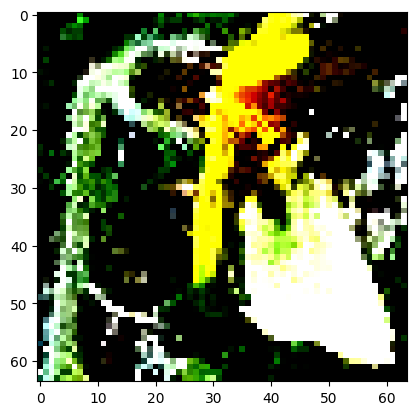

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


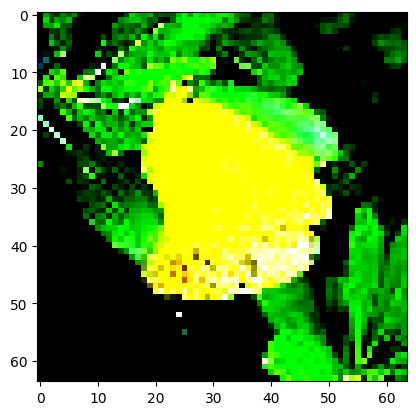

In [10]:
import matplotlib.pyplot as plt

for batch in val_dataloader:
    images, class_nums = batch
    plt.imshow(images[5].permute(1, 2, 0))
    plt.show()
    plt.imshow(images[19].permute(1, 2, 0))
    plt.show()
    break


## Задание 1. 

5 баллов
Добейтесь accuracy на валидации не менее 0.44. В этом задании запрещено пользоваться предобученными моделями и ресайзом картинок.


Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались)
4. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

### Модель (или просто импортируйте не предобученную)

In [22]:
from torchmetrics.functional import accuracy


class YourModule(pl.LightningModule):
    def __init__(self, pretrained: bool = False) -> None:
        """
        Инициализация модуля.
        
        :param pretrained: Флаг, указывающий, использовать ли предобученную модель
        """
        super().__init__()
        # Инициализация модели DenseNet121, если задан флаг pretrained, используется предобученная версия
        if pretrained:
            self.model = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
        else:
            # Или создается новая модель с num_classes=10 (10 классов)
            self.model = densenet121(weights=None, num_classes=10)
        # Инициализация оптимизатора Adam для обновления параметров модели
        self.optimizer = torch.optim.Adam(self.model.parameters())
        # Инициализация функции потерь CrossEntropyLoss для задачи много классовой классификации
        self.loss_fn = nn.CrossEntropyLoss()
        # Инициализация списков для хранения истории значений функции потерь и точности
        self.train_loss_history = []
        self.train_acc_history = []
        self.val_loss_history = []
        self.val_acc_history = []

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Прямое распространение через модель.
        
        :param x: Тензор изображения
        :return: Тензор предсказаний модели
        """
        return self.model(x)

    def configure_optimizers(self) -> tuple[list[Any], list[Any]]:
        """
        Конфигурация оптимизатора и планировщика.
        
        :return: Оптимизатор и планировщик
        """
        # Создание планировщика для изменения learning rate с экспоненциальным затуханием
        scheduler = torch.optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=0.975)
        return [self.optimizer], [scheduler]

    def training_step(self, batch_: torch.Tensor, batch_idx: int) -> torch.Tensor:
        """
        Выполнение одного шага обучения.
        
        :param batch_: Тренировочный батч
        :param batch_idx: Индекс батча
        :return: Значение функции потерь
        """
        # Распаковка батча на изображения и метки
        images_, targets = batch_
        # Прямое прохождение данных через модель
        predictions = self(images_)
        # Вычисление функции потерь
        loss = self.loss_fn(predictions, targets)
        # Вычисление точности с использованием метрики accuracy из torchmetrics
        acc = accuracy(predictions.argmax(dim=-1), targets, num_classes=10, task='multiclass')
        # Логирование функции потерь и точности для обучения
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_acc', acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def on_train_epoch_end(self) -> None:
        """
        Обработчик завершения эпохи обучения.
        """
        # Добавляем значение функции потерь и точности на обучающем наборе в историю
        self.train_loss_history.append(round(self.trainer.callback_metrics['train_loss'].item(), 3))
        self.train_acc_history.append(round(self.trainer.callback_metrics['train_acc'].item(), 3))

    def validation_step(self, batch_: torch.Tensor, batch_idx: int) -> None:
        """
        Выполнение одного шага валидации.
        
        :param batch_: Валидационный батч
        :param batch_idx: Индекс батча
        """
        # Распаковка батча на изображения и метки
        images_, targets = batch_
        # Прямое прохождение данных через модель
        predictions = self(images_)
        # Вычисление функции потерь
        loss = self.loss_fn(predictions, targets)
        # Вычисление точности с использованием метрики accuracy из torchmetrics
        acc = accuracy(predictions.argmax(dim=-1), targets, num_classes=10, task='multiclass')
        # Логирование функции потерь и точности для валидации
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)

    def on_validation_epoch_end(self) -> None:
        """
        Обработчик завершения эпохи валидации.
        """
        # Добавляем значение функции потерь и точности на валидационном наборе в историю
        self.val_loss_history.append(round(self.trainer.callback_metrics['val_loss'].item(), 3))
        self.val_acc_history.append(round(self.trainer.callback_metrics['val_acc'].item(), 3))

In [28]:
seed_everything(123456)

device = "cpu"  # Устройство, на котором будет выполняться обучение модели
model_first_task = YourModule(pretrained=False) # Модель для первой задачи
tensorboard_logger = TensorBoardLogger(save_dir="tb_logs",
                                       name="densenet121") # Объект TensorBoardLogger для записи логов обучения в TensorBoard
trainer = pl.Trainer(max_epochs=10, logger=tensorboard_logger) # Объект Trainer для управления процессом обучения

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [29]:
trainer.fit(model_first_task, train_dataloader, val_dataloader)


  | Name    | Type             | Params
---------------------------------------------
0 | model   | DenseNet         | 7.0 M 
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
7.0 M     Trainable params
0         Non-trainable params
7.0 M     Total params
27.856    Total estimated model params size (MB)


Epoch 0: 100%|██████████| 2/2 [00:08<00:00,  0.25it/s, v_num=1]            
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 2/2 [00:07<00:00,  0.25it/s, v_num=1, val_loss=2.670, val_acc=0.100, train_loss=2.240, train_acc=0.172]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 2/2 [00:08<00:00,  0.25it/s, v_num=1, val_loss=2.500, val_acc=0.146, train_loss=1.880, train_acc=0.354]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 2/2 [00:07<00:00,  0.25it/s, v_num=1, val_loss=2.280, val_acc=0.222, train_loss=1.670, train_acc=0.414]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 2/2 [00:08<00:00,  0.25it/s, v_num=1, val_loss=2.170, val_acc=0.274, train_loss=1.490, train_acc=0.486]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 2/2 [00:08<00:00,  0.24it/s, v_num=1, val_loss=1.950, val_acc=0.318, train_loss=1.370, train_acc=0.548]
Validation: |          | 0/? [00:00<?, ?it/s

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 2/2 [00:11<00:00,  0.17it/s, v_num=1, val_loss=1.550, val_acc=0.468, train_loss=0.862, train_acc=0.726]


### Валидация результатов задания

In [30]:
def evaluate_task(model_: nn.Module,
                  test_dataloader: DataLoader,
                  device_: str = "cpu") -> torch.Tensor:
    """
    Функция для оценки точности модели на тестовом наборе данных.
    
    :param model_: Модель, которая будет оцениваться.
    :param test_dataloader: DataLoader, предоставляющий тестовые данные.
    :param device_: Устройство, на котором будут выполняться вычисления (по умолчанию "cpu").
    :return: Тензор, содержащий значение точности модели на тестовом наборе данных.
    """
    model_ = model_.to(device_)
    model_.eval()
    accuracy_metric = Accuracy(task='multiclass', num_classes=10)

    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device_), labels.to(device_)
        with torch.no_grad():
            outputs = model_(images)
            preds = torch.argmax(outputs, dim=1)
            accuracy_metric.update(preds, labels)

    accuracy = accuracy_metric.compute()
    return accuracy

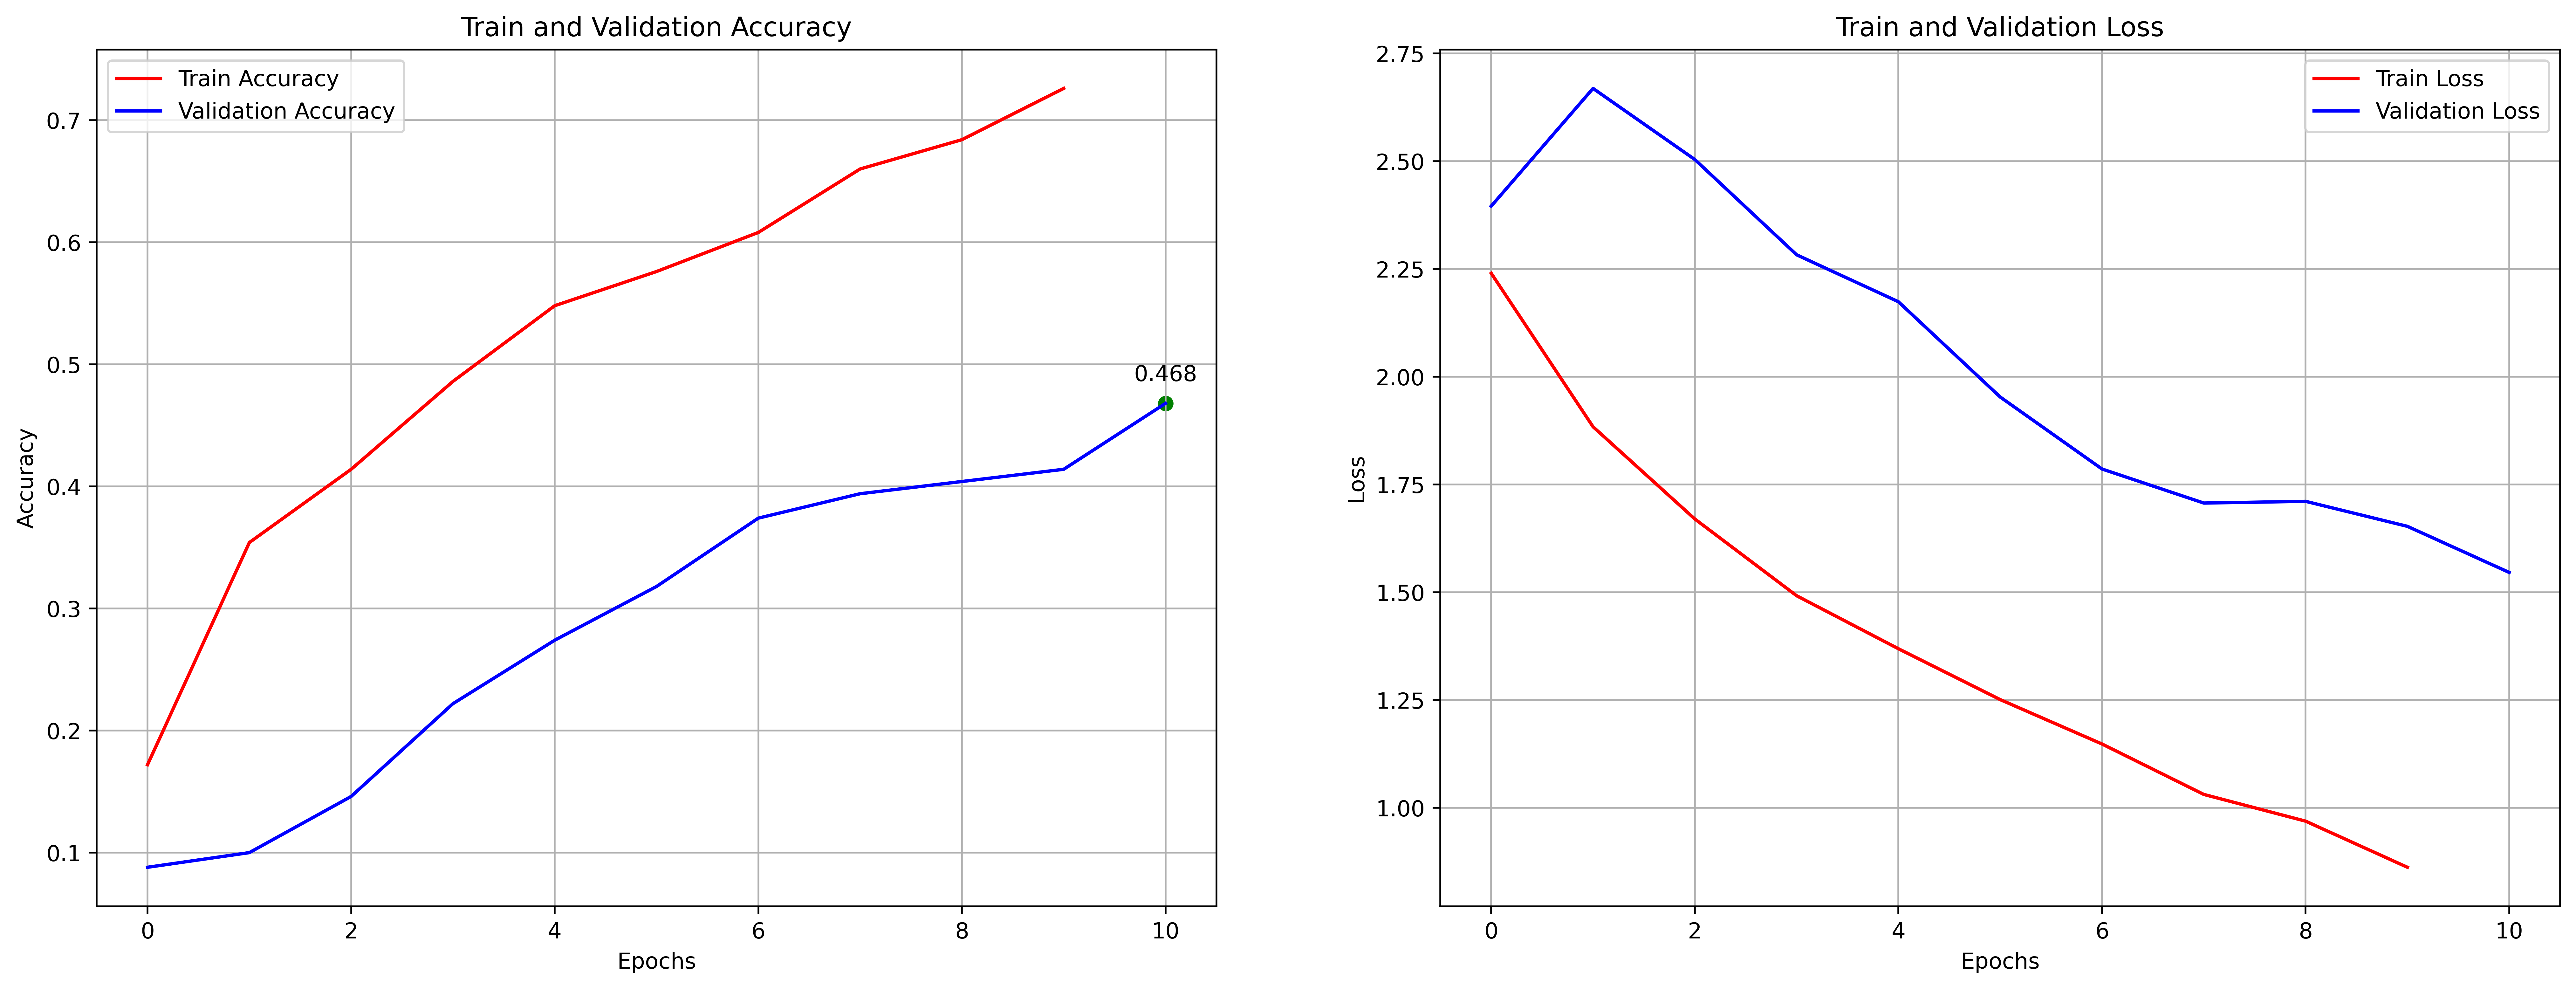

In [31]:
import matplotlib.pyplot as plt

# Находим максимальное значение val_accuracy и соответствующий индекс
max_val_acc = max(model_first_task.val_acc_history)
max_val_acc_epoch = model_first_task.val_acc_history.index(max_val_acc)

# Создаем сетку для графиков: 1 строка, 2 колонки
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7), dpi=500)

# График точности на тренировочном и валидационном наборах
ax1.plot(model_first_task.train_acc_history, label='Train Accuracy', color='red')
ax1.plot(model_first_task.val_acc_history, label='Validation Accuracy', color='blue')
ax1.scatter(max_val_acc_epoch, max_val_acc, color='green')  # Выделяем максимальную точку
# Аннотация максимальной точки
ax1.annotate(f'{max_val_acc}', (max_val_acc_epoch, max_val_acc), textcoords="offset points", xytext=(0,10), ha='center')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_title('Train and Validation Accuracy')
ax1.legend()
ax1.grid(True) 

# График потерь на тренировочном и валидационном наборах
ax2.plot(model_first_task.train_loss_history, label='Train Loss', color='red')
ax2.plot(model_first_task.val_loss_history, label='Validation Loss', color='blue')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Train and Validation Loss')
ax2.legend()
ax2.grid(True)

plt.show()


In [32]:
model_first_task = YourModule.load_from_checkpoint(
    checkpoint_path="tb_logs/densenet121/version_0/checkpoints/epoch=9-step=20.ckpt")

accuracy_first_task = evaluate_task(model_first_task, val_dataloader, device)
print(f"Оценка за это задание составит {np.clip(10 * accuracy_first_task / 0.44, 0, 10):.2f} баллов")


100%|██████████| 2/2 [00:02<00:00,  1.32s/it]

Оценка за это задание составит 10.00 баллов


### Тренировочный класс lightning

## Задание 2

5 баллов
Добейтесь accuracy на валидации не менее 0.84. В этом задании делать ресайз и использовать претрейн можно.

Для того чтобы выбить скор (считается ниже) на 2.5/5 балла (то есть половину за задание) достаточно соблюдать пару простых жизненных правил:
1. Аугментация (без нее сложно очень будет)
2. Оптимайзеры можно (и нужно) использовать друг с другом. Однако когда что-то проверяете, то не меняйте несколько параметров сразу - собьете логику экспериментов
3. Не используйте полносвязные модели или самые первые сверточные, используйте более современные архитектуры (что на лекциях встречались или можете пойти дальше).
4. Попробуйте сначала посмотреть качество исходной модели без дообучения, сохраните как baseline. Отсюда поймете какие слои нужно дообучать.
5. Посмотреть все ноутбуки прошедших семинаров и слепить из них что-то общее. Семинарских тетрадок хватит сверх

### Модель (или просто импортируйте предобученную)

In [37]:
from torchmetrics.functional import accuracy
from torchvision.models import resnet152, ResNet152_Weights


class YourModule2(pl.LightningModule):
    def __init__(self, pretrained: bool = False) -> None:
        super().__init__()
        self.model = resnet152(weights=ResNet152_Weights.IMAGENET1K_V2)
        self.model.fc = nn.Linear(2048, 10)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss = nn.CrossEntropyLoss()
        self.train_loss_history = []
        self.train_acc_history = []
        self.val_loss_history = []
        self.val_acc_history = []

    def forward(self, x) -> torch.Tensor:
        return self.model(x)

    def configure_optimizers(self):
        scheduler = torch.optim.lr_scheduler.ExponentialLR(self.optimizer, gamma=0.975)
        return [self.optimizer], [scheduler]

    def training_step(self, batch_, batch_idx) -> torch.Tensor:
        images_, target = batch_
        predictions = self.forward(images_)
        loss = self.loss(predictions, target)
        acc = accuracy(torch.argmax(predictions, dim=-1).long(), target.long(), num_classes=10, task='multiclass')
        self.log("train_acc", acc, prog_bar=True)
        self.log("train_loss", loss, prog_bar=True)
        return loss
    
    def on_train_epoch_end(self) -> None:
        self.train_loss_history.append(round(self.trainer.callback_metrics['train_loss'].item(), 3))
        self.train_acc_history.append(round(self.trainer.callback_metrics['train_acc'].item(), 3))
        
    def validation_step(self, val_batch, batch_idx) -> None:
        images_, target = val_batch
        predictions = self.forward(images_)
        loss = self.loss(predictions, target)
        acc = accuracy(torch.argmax(predictions, dim=-1).long(), target.long(), num_classes=10, task='multiclass')
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc.item(), prog_bar=True)

    def on_validation_epoch_end(self) -> None:
        self.val_loss_history.append(round(self.trainer.callback_metrics['val_loss'].item(), 3))
        self.val_acc_history.append(round(self.trainer.callback_metrics['val_acc'].item(), 3))


In [38]:
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor

early_stop_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0.00,
    patience=3,
    verbose=False,
    mode='min'
)

lr_monitor = LearningRateMonitor(logging_interval='step')

seed_everything(123456)
model_second_task = YourModule2().to(device)
tensorboard_logger_2 = TensorBoardLogger("tb_logs_new", name="densenet121")
trainer_2 = pl.Trainer(
    max_epochs=54,
    logger=tensorboard_logger_2,

    callbacks=[early_stop_callback, lr_monitor],
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [39]:
trainer_2.fit(model_second_task, train_dataloader, val_dataloader)


  | Name  | Type             | Params
-------------------------------------------
0 | model | ResNet           | 58.2 M
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
58.2 M    Trainable params
0         Non-trainable params
58.2 M    Total params
232.657   Total estimated model params size (MB)


Epoch 0: 100%|██████████| 2/2 [00:20<00:00,  0.10it/s, v_num=6, train_acc=0.0902, train_loss=2.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 2/2 [00:20<00:00,  0.10it/s, v_num=6, train_acc=0.201, train_loss=2.210, val_loss=2.550, val_acc=0.120] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 2/2 [00:18<00:00,  0.11it/s, v_num=6, train_acc=0.295, train_loss=2.120, val_loss=2.310, val_acc=0.194]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 2/2 [00:19<00:00,  0.10it/s, v_num=6, train_acc=0.455, train_loss=1.970, val_loss=2.130, val_acc=0.258]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 2/2 [00:20<00:00,  0.10it/s, v_num=6, train_acc=0.480, train_loss=1.870, val_loss=1.990, val_acc=0.332]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 2/2 [00:21<00:00,  0.09it/s, v_num=6, train_acc=0.545, train_loss=1.770, val_loss=1.870, val_acc=0.376]
Validation: |      

`Trainer.fit` stopped: `max_epochs=54` reached.


Epoch 53: 100%|██████████| 2/2 [00:28<00:00,  0.07it/s, v_num=6, train_acc=1.000, train_loss=0.0289, val_loss=0.568, val_acc=0.818]


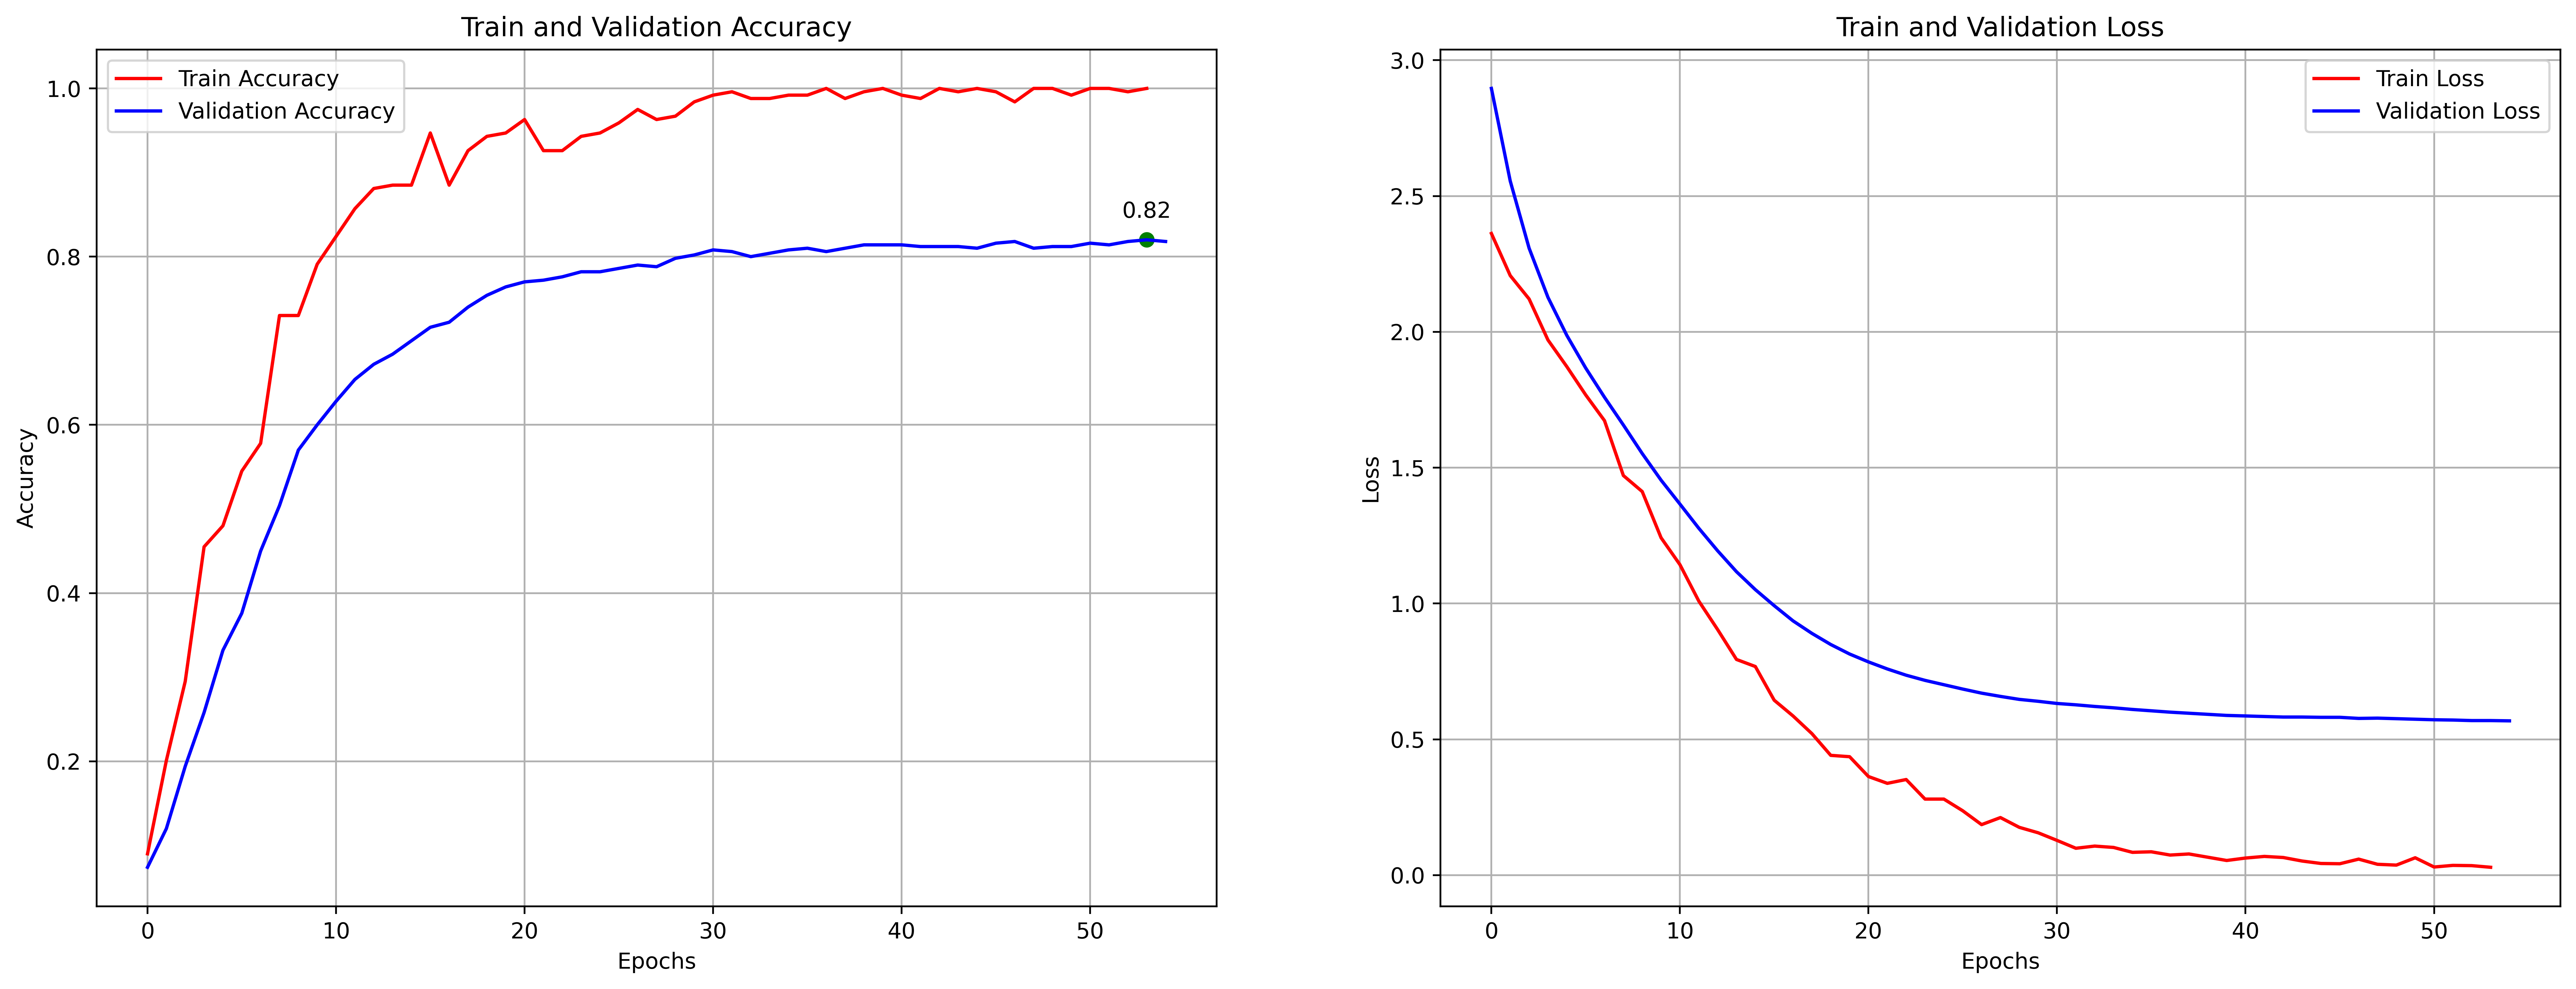

In [40]:
import matplotlib.pyplot as plt

# Находим максимальное значение val_accuracy и соответствующий индекс
max_val_acc = max(model_second_task.val_acc_history)
max_val_acc_epoch = model_second_task.val_acc_history.index(max_val_acc)

# Создаем сетку для графиков: 1 строка, 2 колонки
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7), dpi=500)

# График точности на тренировочном и валидационном наборах
ax1.plot(model_second_task.train_acc_history, label='Train Accuracy', color='red')
ax1.plot(model_second_task.val_acc_history, label='Validation Accuracy', color='blue')
ax1.scatter(max_val_acc_epoch, max_val_acc, color='green')  # Выделяем максимальную точку
# Аннотация максимальной точки
ax1.annotate(f'{max_val_acc}', (max_val_acc_epoch, max_val_acc), textcoords="offset points", xytext=(0,10), ha='center')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_title('Train and Validation Accuracy')
ax1.legend()
ax1.grid(True) 

# График потерь на тренировочном и валидационном наборах
ax2.plot(model_second_task.train_loss_history, label='Train Loss', color='red')
ax2.plot(model_second_task.val_loss_history, label='Validation Loss', color='blue')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Train and Validation Loss')
ax2.legend()
ax2.grid(True)

plt.show()


### Валидация результатов задания

In [43]:
model_second_task = YourModule2.load_from_checkpoint(
    checkpoint_path="tb_logs_new/densenet121/version_6/checkpoints/epoch=53-step=108.ckpt")

accuracy_2 = evaluate_task(model_second_task, val_dataloader)
print(f"Оценка за это задание составит {np.clip(10 * (accuracy_2 - 0.5) / 0.34, 0, 10):.2f} баллов")

100%|██████████| 2/2 [00:05<00:00,  2.56s/it]

Оценка за это задание составит 9.35 баллов


# Отчёт об экспериментах 

текст писать тут (или ссылочку на wandb/любой трекер экспреиментов) для каждого задания, то есть не обязательно именно тут рисовать графики, если вы используете готовые трекеры/мониторинги ваших моделей.

# Задание 1
1. Первое, что я сделал, это уменьшил датасет, сделал 10 классов по 50 картинок, чтобы обучение шло намного быстрее.
2. Второе, что я сделал, это подготовил данные: 
    - *RandomRotation(degrees=15)* -- увеличение обобщающей способности модели путём обучения на повёрнутых изображений. $15$ выбрал потому что большие углы могут привести к более сложным преобразованиям.
    - *RandomVerticalFlip() и RandomHorizontalFlip()* -- случайное изображение по вертикали или горизонтали увеличивает вариативность набора данных, это позволяет распознавать объекты в разных ориентациях.
    - *ToTensor()* -- Преобразование изображений в тензоры PyTorch.
    - *Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))* -- нормализация данных для ускорения сходимости обучения и повышения обобщающей способности модели. Параметры: значения средних *(0.485, 0.456, 0.406)* и стандартных отклонений *(0.229, 0.224, 0.225)* часто выбираются исходя из статистики больших наборов данных. (В инете нашёл код, просто изучил почему так)
3. Третье, что я сделал, это класс *YourModule*, который представляет собой модуль PyTorch Lightning, он предназначен для упрощения процесса обучения нейронной сети. Напишу про все функции подробнее:
- Инициализация(**\_\_init\_\_**) -- происходит инициализация модели, оптимизатора, функции потерь и истории обучения. Флаг **pretrained**, указывает, будет ли использоваться предобученная модель. **self.model** -- инициализация самой модели. **self.optimizer** -- инциализация оптимизатора Adam, который будет обновлять параметры модели. **self.loss_fn** -- функция потерь CrossEntropyLoss. И ещё 4 списка для хранения данных, потому что wandb работает криво косо с ошибками, я не смог его использовать с функцией `evaluate_task`, потом с помощью этих данных строил графики, как они построены -- очень наглядно показано, просто по спискам.
- Прямое распространение(**forward**) -- определяет, как модель обрабатывает входные данные **x**. В данном случае распространение прямое.
- Конфигурация оптимизаторов(**configure_optimizers**) -- данный метод конфигурирует оптимизатор и планировщик частоты обучения. Используется планировщик **ExponentialLR**, который уменьшает скорость обучения в каждую эпоху, умножая на параметр $gamma = 0.975$
- Шаг обучения(**training_step**) -- вызывается для каждого батча во время обучения, здесь данные проходят через модель, вычисляется функция потерь и точность, данные результаты логируются.
- Конец эпохи обучения(**on_train_epoch_end**) -- данный метод вызывается в конце каждой тренировочной эпохи, значения эпохи добавляются в списки.
- Шаг валидации(**validation_step**) -- данный метод аналогичен **training_step**, но выполняется на валидационных данных
- Конец эпохи валидации(**on_validation_epoch_end**) -- данный метод аналогичен **on_train_epoch_end**, но добавляет для валдиацонных данных.
4. Четвёртое, что я сделал, это создал экземпляр модели без загрузки предобученных весов, потом обучил и получил результаты. В первом задании получил $10$, также нарисовал соответствующие графики, как проходило обучение модели обучение.


# Задание 2
1. Первое, что я сделал -- использовал все данные из ***Задания 1***, совсем чуть-чуть изменил класс ***YourModule***, добавив полносвязный слой.
2. Второе, что я сделал, это немного изменил обучение модели. ***EarlyStopping*** -- коллбэк для ранней остановки обучения, с некоторыми параметрами:
- $monitor='val\_loss'$ -- означает, что коллбэк будет отслеживать метрику потерь на валидационном наборе данных.
- $min_delta=0.00$ -- задает минимальное изменение в отслеживаемой метрике, которое будет считаться улучшением, т.е., обучение прекратится, если улучшение метрики меньше этого значения.
- $patience=3$ -- указывает, что обучение будет остановлено, если в течение трех эпох подряд не будет улучшения отслеживаемой метрики.
- $verbose=False$ -- задает, будет ли коллбэк выводить сообщения в процессе работы.
- $mode='min'$ -- указывает на то, что обучение следует остановить, когда метрика перестанет уменьшаться (т.е. мы стремимся минимизировать потери).
Также использовал ***LearningRateMonitor*** -- это коллбэк для мониторинга скорости обучения: использую параметр $logging_interval='step'$, что означает, что скорость обучения будет записываться на каждом шаге. 
3. Обучил модель, нарисовал графики, получилась оценка $9.35$, сил дальше что-то делать нет(
